In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from glob import glob
import random
import os

#CNN
from keras.models import Sequential
from keras.layers import Convolution2D, Flatten, Dense, Input, MaxPooling2D, Dropout
#Metrics
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
!pip install opencv-python



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
paths=[r"C:\Users\bvst2\Desktop\smart Garbage system\DATASET\TRAIN",r"C:\Users\bvst2\Desktop\smart Garbage system\DATASET\TEST"]

In [4]:
labels=[]
for folder in os.listdir(paths[0]):
    labels.append(folder)

dicc_labels = {i:label for i, label in enumerate(os.listdir(paths[0]))}
dicc_labels

{0: 'O', 1: 'R'}

In [5]:
import numpy as np
n=[]
s=80
_images=[]
_labels=[]
for j in range(0,2):
    for i,folder in enumerate(labels):
        try:
            for image in os.listdir(paths[j] +'/'+folder):
                img = os.path.join(paths[j]+'/'+folder+'/'+image)
                img = cv2.imread(img)
                img = cv2.resize(img,(s,s))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                #img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #if you want to use scale gray
                _images.append(img)
                _labels.append(i)
        except:
            print("siuu")
    n.append(len(_images))

_images = np.asarray(_images)
_labels = np.asarray(_labels).astype('int64')
print("images-> ",_images.shape)
print(" datas per label-> ",np.bincount(_labels))

images->  (25077, 80, 80, 3)
 datas per label->  [13966 11111]


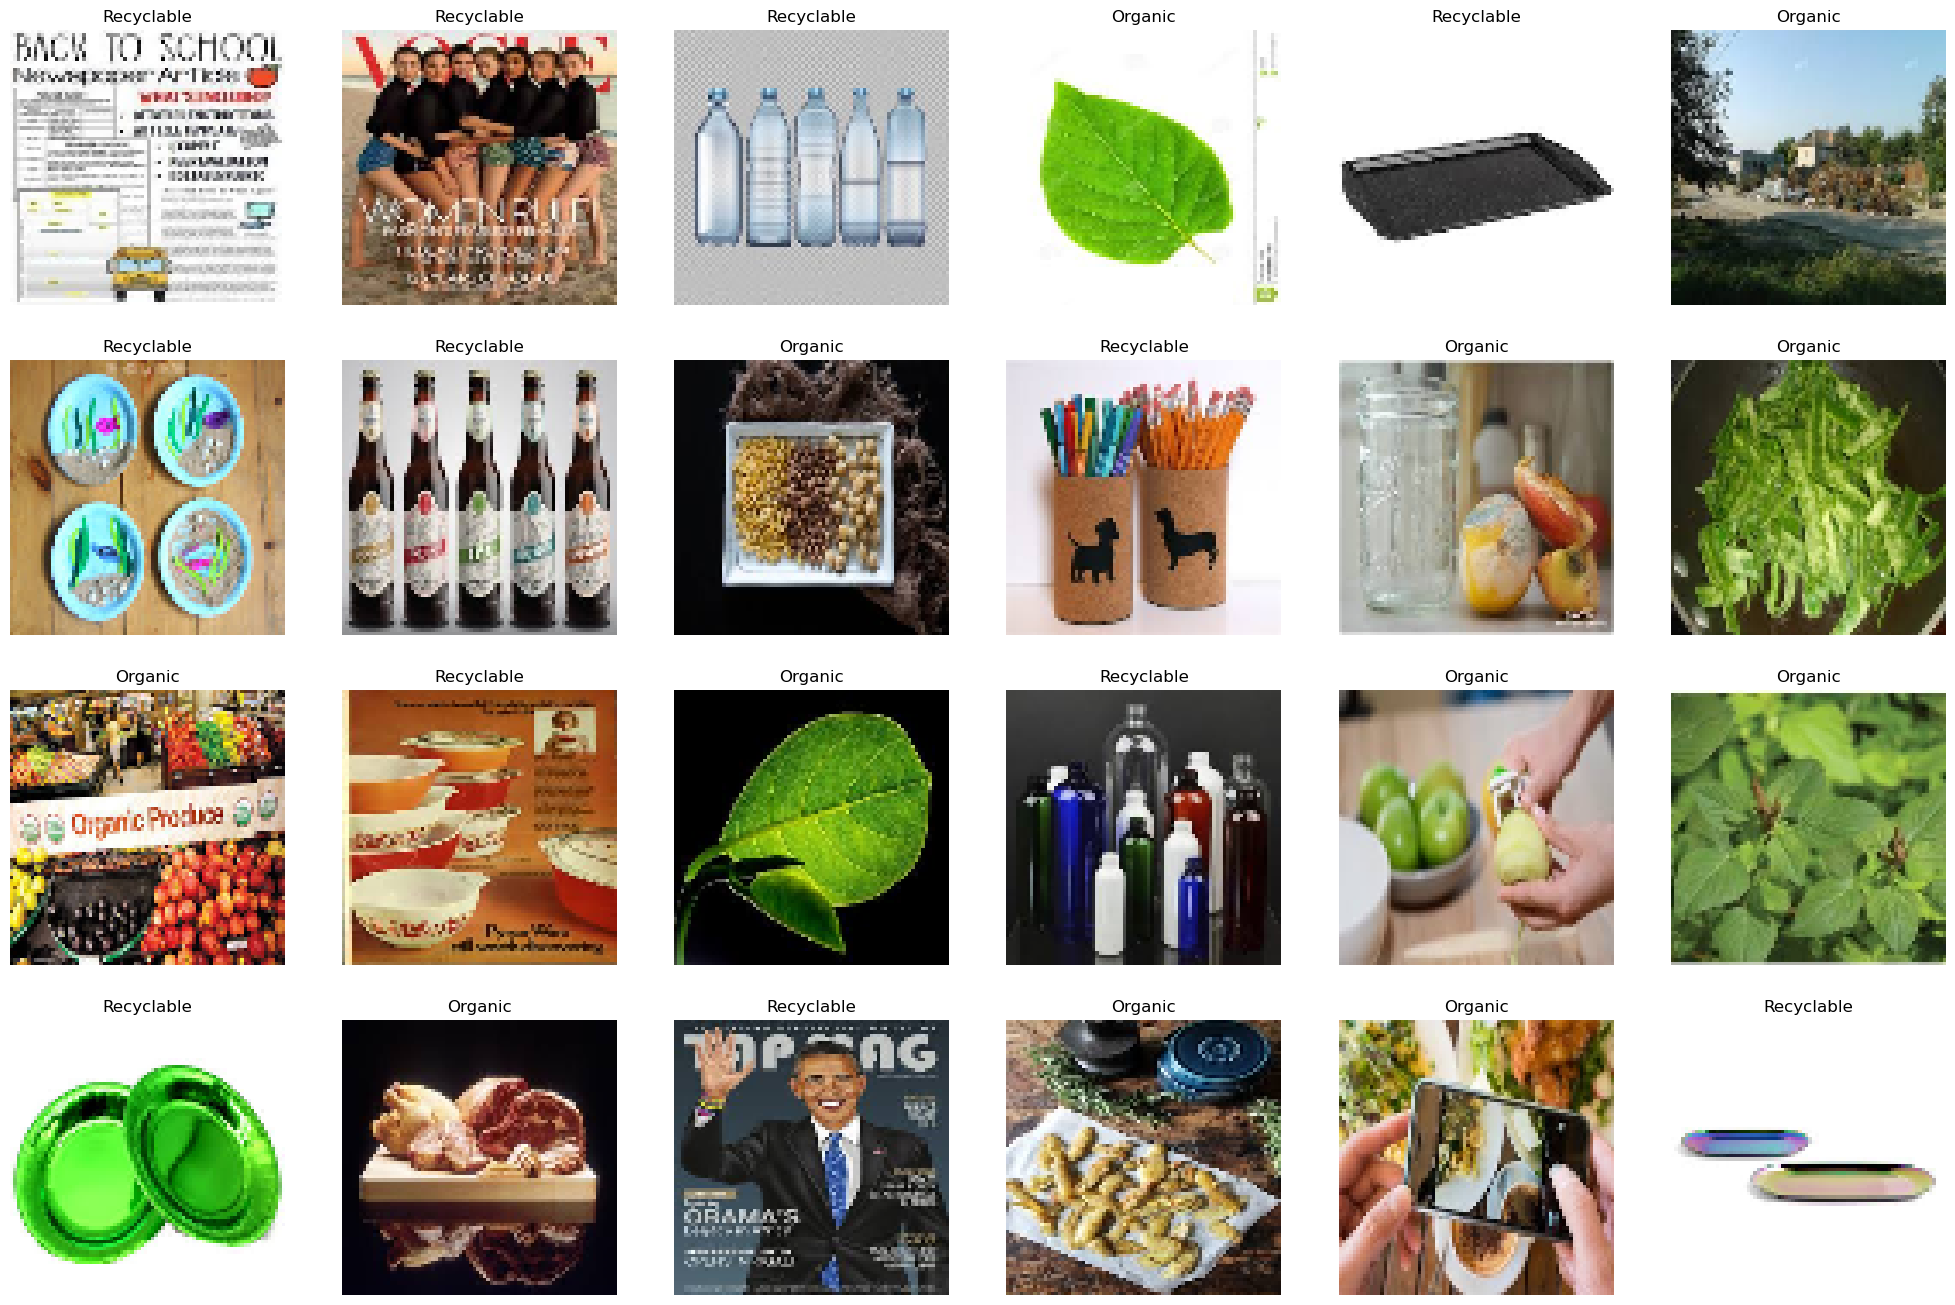

In [6]:
plt.figure(figsize=(25,25))
for i in range(0,24):
    pos= random.randint(0,int(11111+13966))
    plt.subplot(6,6,i+1)
    plt.imshow(_images[pos])    
    plt.axis('off')
    plt.title('Organic' if _labels[pos]==0 else 'Recyclable')

In [7]:
from sklearn.preprocessing import StandardScaler
scal = StandardScaler()
_images =_images.reshape((len(_images),-1))
scal.fit(_images) 
_images_scal = scal.transform(_images) #Genera el nuevo dataset

In [8]:
X_train=_images_scal[0:n[0]]  #[0:22564]
y_train=_labels[0:n[0]] #[0:22564]

X_test=_images_scal[n[0]:n[1]] #[22564:25077]
y_test=_labels[n[0]:n[1]]       #[22564:25077]


X_train =X_train.reshape(len(X_train),s,s,3) # s->size. 80
X_test = X_test.reshape(len(X_test),s,s,3)

print("imagenes train-> ",X_train.shape,"labels train-> ",y_train.shape)
print("labels train por categoría-> ",np.bincount(y_train))
print("imagenes test-> ",X_test.shape,"labels train-> ",y_test.shape)
print("label test por categoría-> ",np.bincount(y_test))


imagenes train->  (22564, 80, 80, 3) labels train->  (22564,)
labels train por categoría->  [12565  9999]
imagenes test->  (2513, 80, 80, 3) labels train->  (2513,)
label test por categoría->  [1401 1112]


In [9]:
y_train[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [10]:
#Number of neurons based on kolmogorov
modelo = Sequential()
modelo.add(Input(shape=(s,s,3)))
modelo.add(Convolution2D(s, kernel_size=3, activation="relu", padding="valid"))
modelo.add(MaxPooling2D(pool_size=(2,2)))
modelo.add(Dropout(0.5))
modelo.add(Convolution2D(s*2, kernel_size=3, activation="relu", padding="valid"))
modelo.add(MaxPooling2D(pool_size=(2,2)))
modelo.add(Dropout(0.5))
modelo.add(Convolution2D(s/2, kernel_size=3, activation="relu", padding="valid"))
modelo.add(MaxPooling2D(pool_size=(2,2)))
modelo.add(Dropout(0.5))
modelo.add(Flatten())
modelo.add(Dense(1, activation="sigmoid"))

modelo.compile(optimizer="adam", loss="binary_crossentropy",
               metrics=["accuracy","Precision"]
)

modelo.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 80)        2240      
                                                                 
 max_pooling2d (MaxPooling2  (None, 39, 39, 80)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 39, 39, 80)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 160)       115360    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 18, 18, 160)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 18, 18, 160)     

Epoch 1/5


706/706 [==============================] - 272s 381ms/step - loss: 0.4472 - accuracy: 0.8023 - precision: 0.7826
Epoch 2/5
706/706 [==============================] - 256s 363ms/step - loss: 0.3754 - accuracy: 0.8425 - precision: 0.8233
Epoch 3/5
706/706 [==============================] - 247s 350ms/step - loss: 0.3470 - accuracy: 0.8585 - precision: 0.8396
Epoch 4/5
706/706 [==============================] - 248s 352ms/step - loss: 0.3324 - accuracy: 0.8634 - precision: 0.8429
Epoch 5/5
79/79 [==============================] - 6s 73ms/step


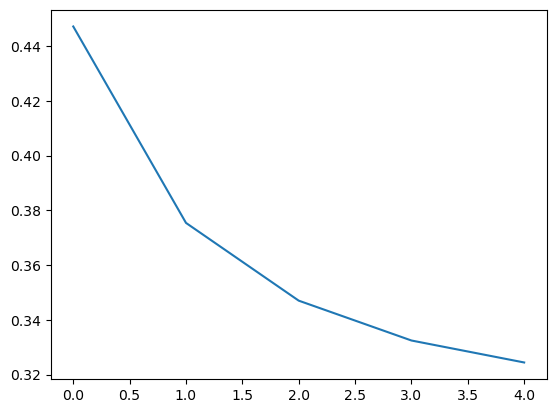

In [11]:
historial=modelo.fit(X_train, y_train, validation_batch_size=(X_test,y_test),epochs=5)
plt.plot(historial.history["loss"])
pred = modelo.predict(X_test)

pred_labels = (pred >= 0.5).astype(int)


<h3>Classification report<h3>

In [12]:

pred = modelo.predict(X_test)
pred=np.where(pred >= 0.5, 1, 0)
print(classification_report(
    y_test,
    pred
))

79/79 [==============================] - 5s 69ms/step
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1401
           1       0.94      0.82      0.88      1112

    accuracy                           0.90      2513
   macro avg       0.91      0.89      0.89      2513
weighted avg       0.90      0.90      0.90      2513



In [13]:
cm=confusion_matrix(y_test,pred)
cm

array([[1345,   56],
       [ 203,  909]], dtype=int64)

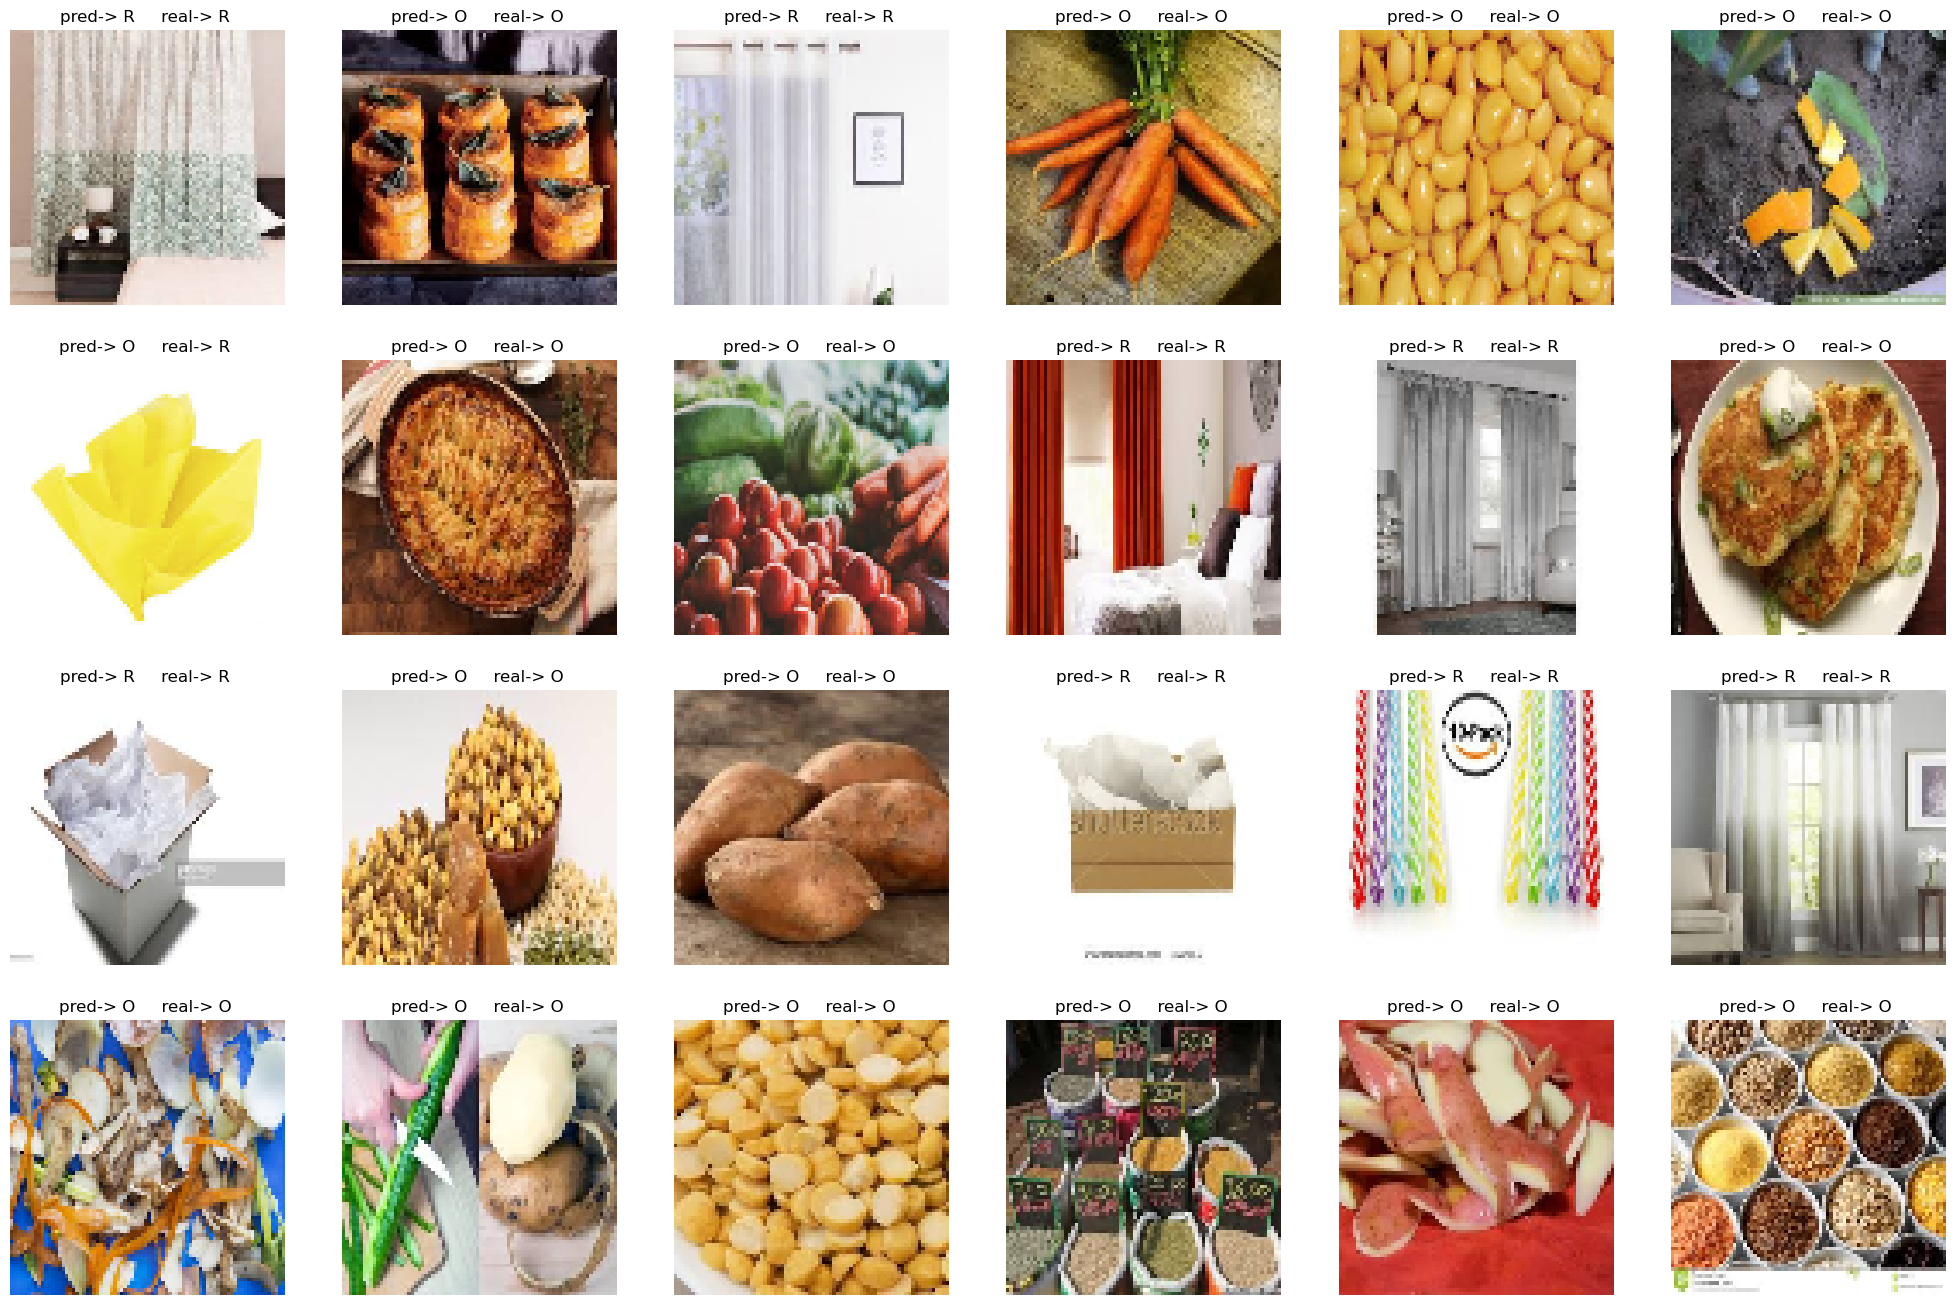

In [14]:

_images =_images.reshape(len(_images),s,s,3)
plt.figure(figsize=(25,25))
for i in range(0,24):
    pos= random.randint(0,int(n[1]-n[0]))
    plt.subplot(6,6,i+1)
    plt.imshow(_images[n[0]+pos])    
    plt.axis('off')
    plt.title("pred-> %s     real-> %s "%(dicc_labels[pred[pos][0]],dicc_labels[y_test[pos]]))

In [15]:
modelo.save('modelo_waste.h5')

C:\Users\bvst2\Desktop\HARSHA\anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
